In [7]:

import numpy as np
import matplotlib.pyplot as plt
import helpers as hp




In [8]:
string = "test_var"
globals()[string] = 42

# thats cool, didnt know you could dynamically declare variables
test_var

42

In [13]:
dirname = "thorney_testdir2"
barrier_left_conductance_left_arr = hp.np_load_wrapped("barrier_left_conductance_left_arr", dirname)
barrier_left_conductance_right_arr = hp.np_load_wrapped("barrier_left_conductance_right_arr", dirname)
barrier_right_conductance_left_arr = hp.np_load_wrapped("barrier_right_conductance_left_arr", dirname)
barrier_right_conductance_right_arr = hp.np_load_wrapped("barrier_right_conductance_right_arr", dirname)
dIdVs_left_arr = hp.np_load_wrapped("dIdVs_left_arr", dirname)
dIdVs_right_arr = hp.np_load_wrapped("dIdVs_right_arr", dirname)
energies = hp.np_load_wrapped("energies", dirname)
ldos = hp.np_load_wrapped("LDOS", dirname)
Tinvs_left = hp.np_load_wrapped("Tinvs_left", dirname)
Tinvs_right = hp.np_load_wrapped("Tinvs_right", dirname)


In [16]:
mu = 1
Delta = 0.5
V_c = np.sqrt(mu**2 + Delta**2)
num_vz_var = 150
Vz_var = np.linspace(0.3, 1.7, num_vz_var) 
Vzs = V_c * Vz_var


len dIdVs_left_arr: (150, 100)
len Vzs: 150
len energies: 100


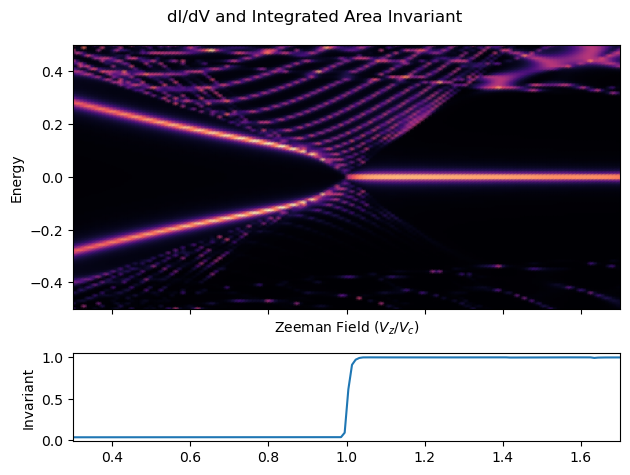

In [22]:
print(f"len dIdVs_left_arr: {dIdVs_left_arr.shape}")
print(f"len Vzs: {len(Vzs)}")
print(f"len energies: {len(energies)}")

Y,X= np.meshgrid(energies, Vz_var)
Z = dIdVs_left_arr
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, gridspec_kw={'height_ratios': [3, 1]})
mesh = ax1.pcolormesh(X, Y, Z, cmap='magma', shading = 'gouraud')

ax1.set_xlabel(r"Zeeman Field $(V_z/V_c)$") # Now the x-axis
ax1.set_ylabel("Energy") # Now the y-axis

ax2.plot(Vz_var, 1- Tinvs_left)
ax2.set_ylabel("Invariant")

fig.suptitle(r"dI/dV and Integrated Area Invariant")

fig.tight_layout()
#ax1.set_aspect(0.7)
#fig.colorbar(mesh, ax=ax, label="Conductance")


0.6100671140939598


Text(0, 0.5, 'dI/dV')

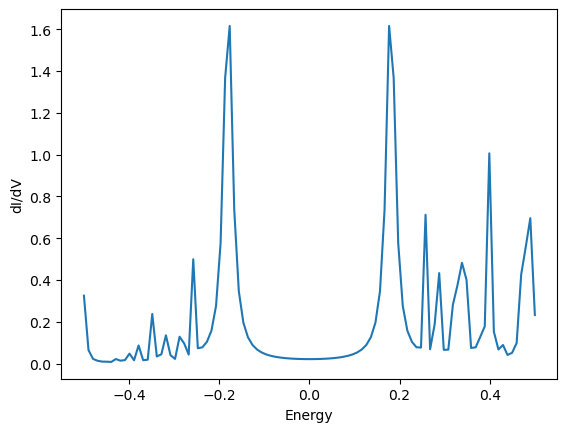

In [49]:
idx = 33
print(Vz_var[idx])
plt.plot(energies, dIdVs_left_arr[idx,:])
plt.xlabel("Energy")
plt.ylabel("dI/dV")